# Decoder Metrics and (Temporal) Parallel Window Decoding

Decoders are at the heart of QEC.  In the previous QEC 101 lesson called "[Decoders](https://github.com/NVIDIA/cuda-q-academic/blob/main/qec101/04_QEC_Decoders.ipynb)" you learned about the role of decoders and some of the different approaches to decoding.

As QEC matures as a field, research is expanding from its origins in pure theory to experimental demonstrations of QEC workflows on physical QPUs.  As QPUs continue to scale, it is becoming increasingly important to consider how every aspect of a QEC workflow scales such that it is possible to run fault-tolerant logic on devices with millions of qubits.

Decoders are likely the primary bottleneck of QEC, so it becomes critically important to understand the nature of these bottlenecks and what sorts of solutions will scale or not. 

This notebook will explore the key metrics of decoders, giving you a better intuition for some of the most important practical considerations for decoders and why they matter. It will also explore a scalable decoding scheme called temporal parallel window decoding which has promise to help overcome some of challenges faced with QEC decoding.

**Prerequisites:** This lab assumes you have a moderate knowledge of QEC and have completed the core QEC 101 courses (labs 1-4), especially the labs covering [stabilizers](https://github.com/NVIDIA/cuda-q-academic/blob/main/qec101/02_QEC_Stabilizers.ipynb) and [decoders](https://github.com/NVIDIA/cuda-q-academic/blob/main/qec101/04_QEC_Decoders.ipynb). 

**What you will do:**
* Learn the three primary decoder metrics: accuracy, throughput, and reaction time.
* Run simulations to understand the throughput backlog problem.
* Learn about sliding and temporal parallel window decoding.
* Understand how reaction time impacts QPU clock speed.

**Terminology you will use:**
* throughput, accuracy, reaction time
* the exponential backlog problem
* sliding window decoding
* parallel window decoding


## 8.1 The Key Decoder Metrics

Recall that the job of a decoder is to take syndromes measured from a quantum computer and a parity check matrix ($H$), defining the parity constraints of the QEC code, and determine where errors occurred so they can be fixed. Decoding a single syndrome extraction round can reveal errors in space, but certain errors, such as measurement errors, can only be caught when decoding in time, using a larger $H$ that can decode multiple rounds of syndrome data. 

Decoders can be assessed by three primary metrics:

1. **Accuracy** - The ability to correctly identify errors.
2. **Throughput** - The rate at which the decoder processes syndrome data.
3. **Reaction time** - The time between when the last syndrome is sent from the QPU and the decoder returns a correction.

Accuracy is fairly straightforward.  If a decoder makes poor predictions, logical errors occur which results in poor outcomes from the quantum algorithm.  This is usually measured by a logical error rate.  We will not discuss accuracy much here, but note that there is often a tradeoff between decoder accuracy and its scalability with respect to the number of syndromes decoded in a single block. 

Throughput measures how fast syndromes can be processed by the decoder. This rate ($r_{proc}$) must be faster than the rate at which syndromes arrive from the quantum computer $r_{gen}$. If syndromes arrive faster than they are processed, a backlog starts to build up and the decoder grinds to a halt. 

Consider an example of the steady-state intercircuit feed-forward latency (SIFL) benchmark shown below. Each step involves preparation of a single logical qubit. Then, 10 syndrome extraction rounds are performed, and the decoder runs. The results of the decoder inform the logical measurement which informs feed-forward application of an $X$ gate. 


<figure>
  <img src="Images/parallel/sifl.png" alt="plot" width="1200">
</figure>

Though this circuit is entirley Clifford, meaning the errors could be tracked an applied at the end, it is a good model for the procedure necessary to apply non-Clifford gates like Toffoli gates or $T$ gates (shown below) which requires feedback from the decoder to perform condition logical at each gate application. (I.e., errors can not be tracked an applied at the end of the algorithm.)


<figure>
  <img src="Images/parallel/T_teleport.png" alt="plot" width="600">
</figure>

As demonstrated in the SIFL figure, if $r_{gen}$ < $r_{proc}$, then each step continues with a constant decoder latency $L_i$ (Top). If $r_{gen}$ > $r_{proc}$, a buildup of unprocessed syndromes occurs (bottom) and each subsequent decoder step becomes slower and slower before the next $X$ gate is applied.  

In Therhal's paper "[Quantum Error Correction for Quantum Memories
](https://arxiv.org/pdf/1302.3428)", the argument is made that this backlog becomes a serious problem and grows exponentially with the number of qubits.  This means that a decoder with a sufficient throughput is a non-negotiable for QEC.


The final metric "reaction time" essentially sets the limit on the wall clock time for the QPU.   It is likely that FTQC circuits will be overwhelmingly limited by application of $T$ or other non-Clifford gates that require feed-forward information from the decoder before proceeding to the next gate.


The reaction time is composed of two main components. First, the latency which is the time from the last syndrome produced by the QPU to the decoder returning its result ($T_{decode}$).  The second is the communication overhead from the decoder to the QPU via the classical control system ($T_{latency}$). 

$$ T_{reaction}=T_{decode}+T_{latency}$$

Though reaction time is not as critical as throughput, it may be a major practical limitation for completing quantum algorithms with many non-Clifford gates in a reasonable amount of time.


A final honorable mention in the discussion of metrics is scalability. Though, not a metric per se, it is important to remember that any decoder, no matter how promising, needs to scale. Thus, today's research efforts should be directed towards the methods which have the greatest potential to scale and avoid those with proven limitations. 



<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 1:</h3>
    <p style="font-size: 16px; color: #333;">
Use the $\texttt{QECSimulator}$ below to explore the exponential backlog problem.  To setup the simulation, input the $\texttt{syndrome\_time\_us}$ which is the time in microseconds for a single syndrome extraction from the QPU (this defines $r_{gen}$ ). The $\texttt{min\_batch\_size}$ specifies the number of syndromes needed to send a batch to the decoder. $\texttt{decode\_fun}$ is a lambda expression which computes how long it will take to decode all $n$ syndromes.  This is an important variable to toggle, as the most accurate algorithmic decoders can scale exponentially in terms of the number of syndromes they are decoding. $\texttt{max\_batches\_to\_run}$ ensures the simulation stops at a reasonable point.  Keep $\texttt{n\_processors}$ equal to 1 for now.

Run the simulation as defined below where the decoder scales linearly with the number of syndromes to decode, but is faster than the syndrome generation rate. What happens to the system load (number of syndromes yest to resolve including backlog and those with the decoder) and the decoding time.  
</div>


Running Scenario 1...


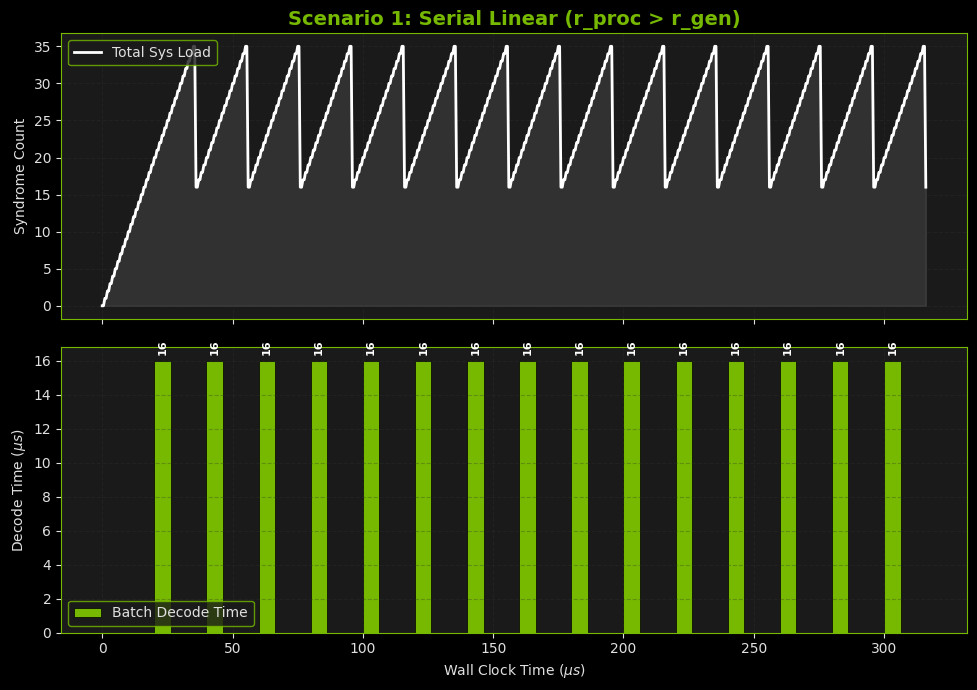

In [1]:
from Images.parallel.decoder_simulator import QECSimulator

print("Running Scenario 1...")
sim1 = QECSimulator(
    syndrome_time_us=1.0,
    min_batch_size=20,
    decode_func=lambda n: n * 0.8, 
    max_batches_to_run=15,
    n_processors=1
)
sim1.run()
sim1.plot_results("Scenario 1: Serial Linear (r_proc > r_gen)")

Now, keep the decode function linear, but change the scaling factor so it is slightly slower than the syndrome generation rate.  What happens to the system load and batch decoding times?

Running Scenario 2...


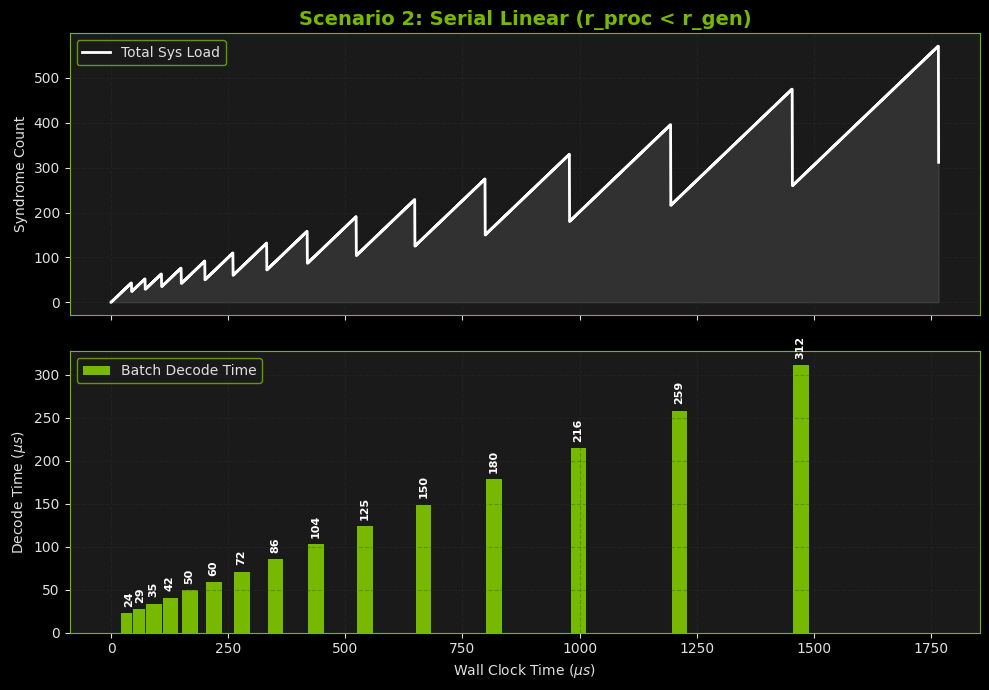

In [2]:
print("Running Scenario 2...")
sim1 = QECSimulator(
    syndrome_time_us=1.0,
    min_batch_size=20,
    decode_func=lambda n: n * 1.2, 
    max_batches_to_run=15,
    n_processors=1
)
sim1.run()
sim1.plot_results("Scenario 2: Serial Linear (r_proc < r_gen)")

Now, make the decoder quadratic with the following decode function to better resemble a a decoder in practice deployment: $f(n) = 0.01 *n^2$.

Running Scenario 3...


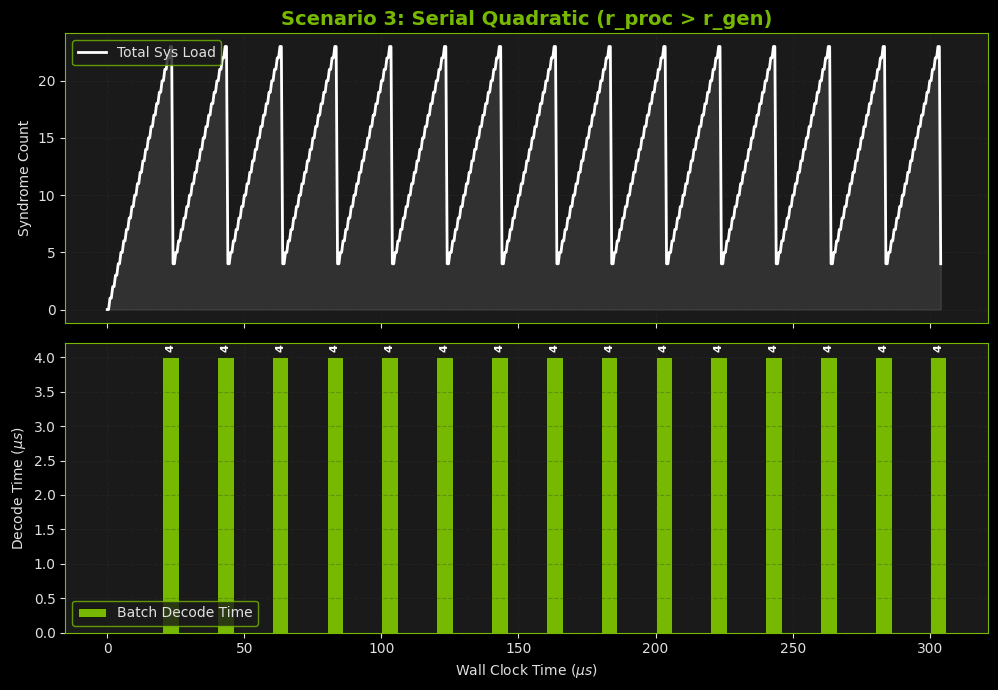

In [3]:
print("Running Scenario 3...")
sim1 = QECSimulator(
    syndrome_time_us=1.0,
    min_batch_size=20,
    decode_func=lambda n: 0.01*n ** 2, 
    max_batches_to_run=15,
    n_processors=1
)
sim1.run()
sim1.plot_results("Scenario 3: Serial Quadratic (r_proc > r_gen)")

Even a quadratic scaling decoder can perform well if it is handling a small enough batch of syndromes to keep up, but try changing the prefactor to $f(n) = n^2$ and see what happens. 

Running Scenario 4...


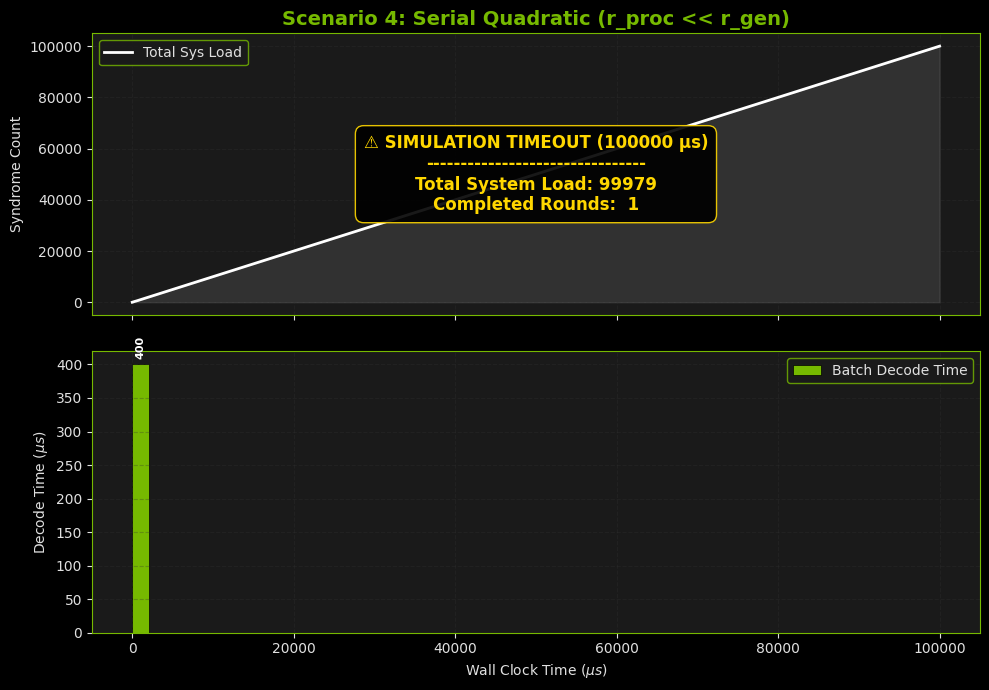

In [4]:
print("Running Scenario 4...")
sim1 = QECSimulator(
    syndrome_time_us=1.0,
    min_batch_size=20,
    decode_func=lambda n: n ** 2, 
    max_batches_to_run=10,
    n_processors=1
)
sim1.run()
sim1.plot_results("Scenario 4: Serial Quadratic (r_proc << r_gen)")

The simulation can decode the first batch reasonably fast, but the backlog is so severe, the second batch takes 160,000 microseconds! And the simulation continues to blow up after this.  Clearly, a more effective method is needed when accurate decoders are required and $r_{proc} < r_{gen}$.

One additional note.  The 1 microsecond times for syndrome extraction are in the ballpark for superconducting devices.  For slower modalities like ion traps, the same decoder setup may work fine simply because it take so much more time to perform syndrome extraction.  Try running the analysis one more time but using a syndrome extraction time of 200 microseconds.

Running Scenario 5...


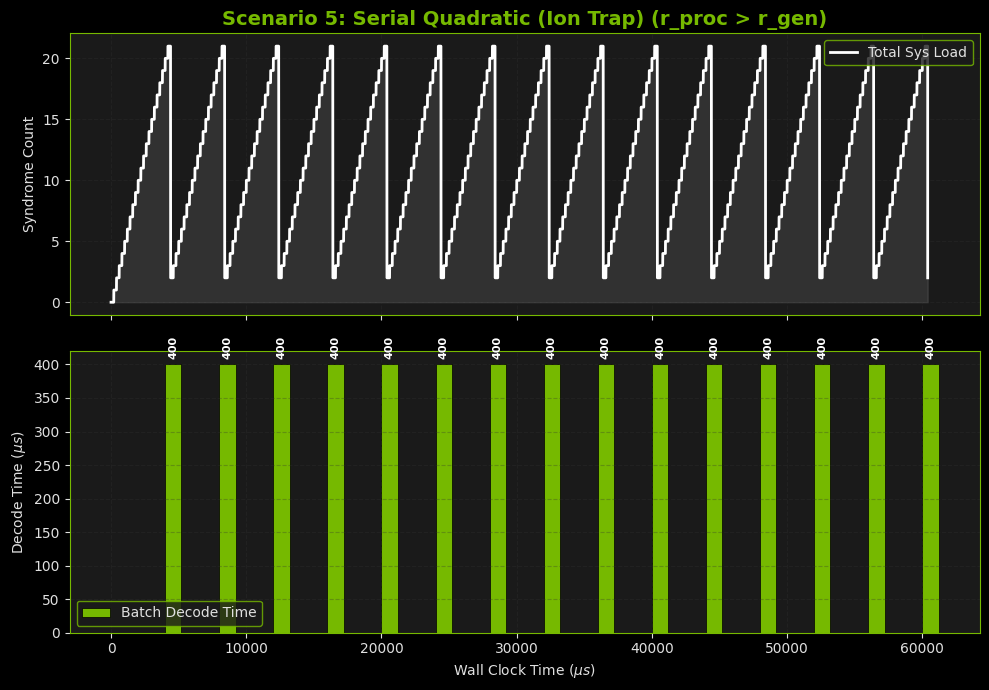

In [5]:
print("Running Scenario 5...")
sim1 = QECSimulator(
    syndrome_time_us=200.0,
    min_batch_size=20,
    decode_func=lambda n: n ** 2, 
    max_batches_to_run=15,
    n_processors=1
)
sim1.run()
sim1.plot_results("Scenario 5: Serial Quadratic (Ion Trap) (r_proc > r_gen)")

Thus, different decoders may be better suited for different qubit modalities and a whole host of other factors.

## Parallel Window Decoding

The throughput problem is serious, and finding clever ways to increase decoder throughput is necessary to ensure the viability of real-time decoding. Accelerated computing has helped solve simulation problem across all domains of science by massively parallelizing scientific computing and boosting throughput by orders of magnitude. The QEC field is primed to benefit from such an approach as well and this section will build towards a scheme called parallel window decoding which can ameliorate the throughput problem. 

Building up from a simple model.  If a circuit was entirely composed of Clifford gates, it could be run and all syndromes be decoded after its completion as a single postprocessing step.  Unfortunately, the benefits of quantum algorithms comes from non-Clifford gates like $T$ gates which require feedback from a decoder at each application. (See teleportation circuit in previous section.) This means a decoder needs to work alongside the QPU in realtime. The magic states that produce $T$ gates can also decohere if the decoder backlog is too high. Thus, clever parallel decoding schemes are required to solve the problem.

Let's consider decoding for a single set of $d$ stabilizer rounds performed between two arbitrary $T$ gates. One approach to decoding these could be waiting for all $d$ rounds to finish and then decoding them all at once. (Your python script above does currently.) This block decoding will be the slowest approach possible as the decoder must process a massive parity (that covers all syndromes) at once.

<figure>
  <img src="Images/parallel/alldecode.png" alt="plot" width="500">
</figure>

Aside from the more difficult decoding task, this approach cannot start until all of the syndromes are collected so there is no chance for a headstart. 

A second, far more common approach is called **sliding window**. The idea is to decode slices of the syndrome data and feed the results into the next decoding task.  One advantage is that the decoding task is much smaller as the "sliding window" covers fewer syndromes at the same time.  A second advantage is that the decoder can start working on the first window as soon as it is ready rather than waiting for all of the syndrome data to be generated.


<figure>
  <img src="Images/parallel/sliding.png" alt="plot" width="500">
</figure>

Even though the decoder gets a head start, the decoding must still occur in serial as each decoding step cannot begin until the previous is finished. Thus, sliding window decoding will quickly run into scaling problems.

The solution to this is **parallel window** decoding as presented in the paper entitled ["Parallel window decoding enables scalable fault tolerant quantum computation"](https://www.nature.com/articles/s41467-023-42482-1). Parallel window decoding can be applied with respect to time (temporal) or space (spatial).  For this lesson we will focus on temporal parallelism only, but know that similar techniqies could be used to break down a large QEC code patch spatially.

In temporal parallel window decoding, the entire block of syndrome history is obtained and then broken down into sub-blocks that can run in parallel on $N_{proc}$ number of processors in two steps: decoding and cleanup.




<figure>
  <img src="Images/parallel/pw_decoding_diagram.png" alt="plot" width="500">
</figure>

The decoding step first commits error assignments in specififed regions while the second cleans up the boundaries to rectify errors between the commit regions as shown in the image below.


<figure>
  <img src="Images/parallel/pw_schematic.png" alt="plot" width="1000">
</figure>

Consider the central commit region in green.  There are $n_{com}$ syndromes needed for the decode step.  The commit regions are then flanked by buffer regions where syndromes are partially processed, but the results cannot be certain yet.  The commit regions are the solved boundaries for the syndromes processed in the second cleanup step. Here, $n_w$ syndromes are processed to determine errors in the two overlapping buffer regions plus any addition syndromes between them.  

As you can see from the figure, this pattern repeats for as many processors and sub-blocks as necessary.  For counting purposes, the smallest sub-block hat can be processed in this manner consists of $n_{com} +n_W$ syndromes. There are many potential choices for the size of these regions.  For example, the ["Parallel window decoding enables scalable fault tolerant quantum computation"](https://www.nature.com/articles/s41467-023-42482-1) paper sets $n_{com} =d$ and $n_w = 3*d$. Techniqes like "[temporal encoding of lattice surgery](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.3.010331)" can allow for a smaller number of syndrome extraction rounds to be used, improving the throughput of the decoder even more by minimizing the sub-block decoding task.

To avoid an exponential backlog if we have a single decoder, the following inequality must hold. 

$$ (n_{com} +  n_w)t_{syndrome-extraction} \geq 2 * t_{decode} $$

At face value this seems like a more challenging decoding task relative to the standard approach as $t_{decode}$ now has a factor of 2.  The trick is that this construction, though requiring two steps, can be attacked with any number of processors $N_{proc}$ so instead the following must hold.

$$  N_{proc}(n_{com} +  n_w)t_{syndrome-extraction} \geq 2 * t_{decode} $$

This means that a slow decoder using parallel window decoding can still avoid the exponential backlog problem by using an arbitrary number of decoder in parallel up to the limit of the smallest sub-block decoding task.   Such an approach has replaced the viability of sliding window and provides a much more promising path to scalable QEC.


<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 2:</h3>
    <p style="font-size: 16px; color: #333;">
Use the QEC Simulator above and determine how many processors are required to keep up with the quadratic scaling decoder you tested earlier.  Note, that the simulator considers the fact that two decoding rounds are required for parallel window decoding, however the simulator is simplified and divides the syndromes to process into $N$ blocks approximating the procedure to form a buffer zone. 
</div>




Running Scenario 6...


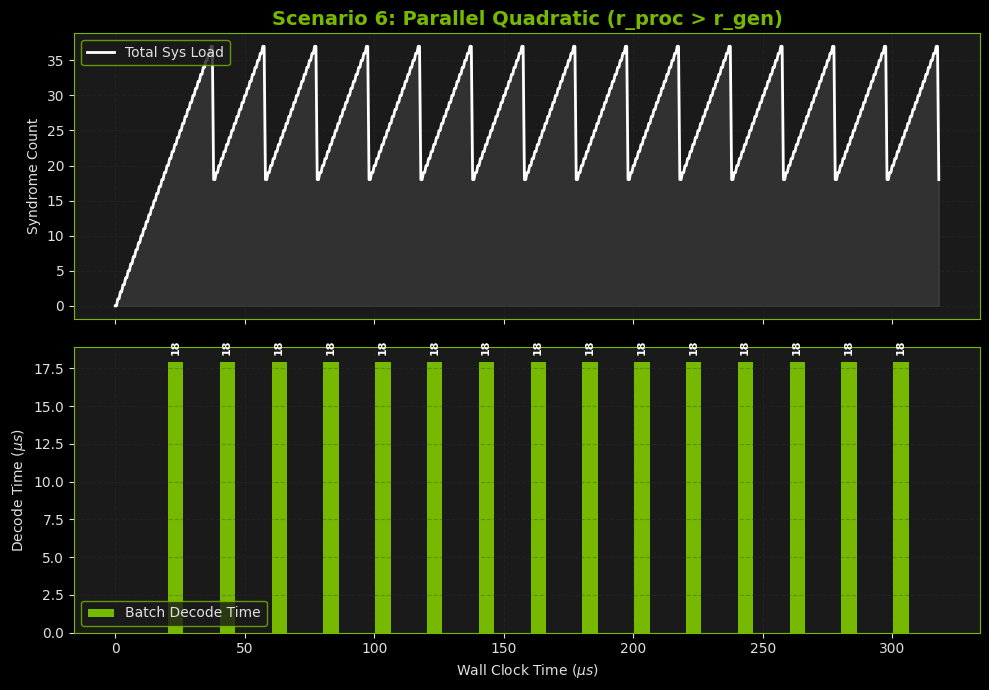

In [6]:
print("Running Scenario 6...")
sim1 = QECSimulator(
    syndrome_time_us=1.0,
    min_batch_size=20,
    decode_func=lambda n:  n ** 2, 
    max_batches_to_run=15,
    n_processors=7
)
sim1.run()
sim1.plot_results("Scenario 6: Parallel Quadratic (r_proc > r_gen)")

The key takeaway here is that it is often necessary to take a massive decoding task and spend the overhead to distribute it across AI supercomputing resources to avoid the exponential backlog.  This is a primary motivation for why GPUs are powerful tools for QEC, even if they might have greater latency than other alternatives.

## Decoder Latency and Reaction Time

Assuming the throughput problem is solved, latency becomes the next critical factor.  The latency is the time it takes from the QPU producing the last syndrome to the when the decoder obtains a result for this syndrome.  This is closely related to a similar quantity called reaction time which also includes the time it takes to transmit the result through the classical control systems.

Rerun your parallel decoding simulation above, but this time use 100 decoders. What happens to the decode time?  


Running Scenario 7...


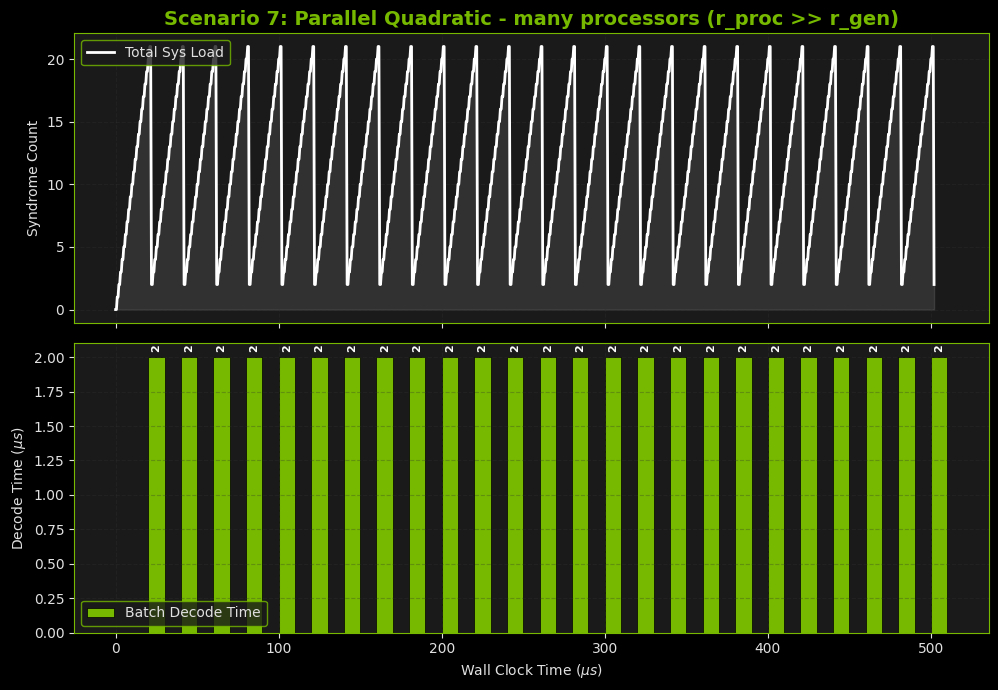

In [7]:
print("Running Scenario 7...")
sim1 = QECSimulator(
    syndrome_time_us=1.0,
    min_batch_size=20,
    decode_func=lambda n:  n ** 2, 
    max_batches_to_run=25,
    n_processors=100
)
sim1.run()
sim1.plot_results("Scenario 7: Parallel Quadratic - many processors (r_proc >> r_gen)")

Notice each decoder task is much faster so the result can also be returned to the QPU much faster and progress the quantum computation. Note that more processors can improve the latency, but they are still limited by twice the time it takes to decoder a fundamental block.  Though this simulator can arbitrarily compute smaller times to give a qualitative depiction of this, in practice, the previous discussion about the size of the buffer and commit regions determines the limit on latency.

why does this matter?

The main bottleneck of a quantum algorithm is the execution of the non-Clifford gates like $T$ gates. Recall from the lesson ["$T$ Gates and Magic State Distillation"](https://github.com/NVIDIA/cuda-q-academic/blob/main/qec101/05_QEC_MSD.ipynb) that $T$ gates are generally prepared by using an asynchronously generated $\ket{T}$ state via a costly process called magic state distillation (MSD).  The $\ket{T}$ states are stored and applied as needed via the teleportation circuit shown in the first section of the notebook.  


A quantum algorithm will be constrained regardless, but there are a number of tradeoffs that can be considered. If the MSD process is slow and few $\ket{T}$ states are on hand, then MSD becomes the bottleneck for QPU computation speed.  If the number of $\ket{T}$ states is abundant, then the decoder's reaction time becomes the bottleneck as the decoder must return its result before the next $T$ gate can be applied.

This means that decoding will usually be the primary bottleneck for the QPU wall clock time and might be the difference between an algorithm completing in a reasonable amount of time or not.  This is why decoders need to be as fast as possible (even when the throughput problem is solved) and connect to the quantum control devices with interconnects optimized for latency such as [NVIDIA's NVQLink](https://www.nvidia.com/en-us/solutions/quantum-computing/nvqlink/).

Additional space and time tradeoffs can be considered with methods like autocorrected $T$ gates, where $T$ gates proceed without resolving the necessary Clifford correction which is instead tracked as part of the quantum algorithm, speeding up the wall clock time.  However, this time savings requires a space cost in the form of additional ancillas for every $T$ gate.  Neither approaches resolves the underlaying constraints but, like many aspects of quantum computing, allows for selection of tradeoffs depending on the application.


## Summary

After completing this lab, you should now have a better understanding for why decoding is so difficult and what specific metrics need to be considered when using a decoder in practice.  A key takeaway is that the throughput problem is an absolute dealbreaker for decoders.  If a decoder cannot process syndromes as fast as they are obtained from the QPU, it will result in an exponential backlog that grinds everything to a halt. 

Parallel window decoding is an innovative solution to this problem that allows many processors working in tandem to solve the throughput problem.  

Response time and accuracy are also very important and might impose severe practical limitations on a QEC workflow, but these are secondary to throughput.